# Predicting Housing Prices in Ames City
<ol>
    <li>Loading & Preparing the Data</li>
    <li>Exploratory Data Analysis</li>
    <li>Imputing Missing Values & Encode Featues</li>
    <li>Dealing with Outliers</li>
    <li>Feature Engineering:</li>
    <ol>
        <li>Convert Numerical Features which are actually Categorical</li>
        <li>Label Encoding the Remaining Ordinal Categorical Features & Categorising our Nominal Categorical Features</li>
        <li>Feature Analysis & Extraction</li>
        <li>One Hot Encoding of Nominal Categorical Features</li>
        <li>Feature Transformation: Making Non-Gaussian Features Gaussian with PowerTransformer</li>
        <li>Standardisation</li>
    </ol>
    <li>Process our Data</li>
    <li>Build Baseline LASSO Model on Training Subet, Error Analysis & Further Feature Selection</li>
    <li>Train LASSO Model on entire Training Set</li>
    <li>Output Wrangled Data for Further Model Development</li>
</ol>


In [1]:
# Load useful libraries
import pandas as pd
#!pip install pandas_profiling
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install yellowbrick
import eli5
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. Loading & Preparing our Data

In [2]:
# Training Set
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
# Inspect our Training Data
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Inspect our Feature Datatypes
train_data.info()
# 38 Numerical Features & 43 Categorical Features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Split our Training, Cross Validation & Testing Data into: X - Explanatory Features & Y - Target Feature (SalePrice)
X = train_data.drop(columns=["Id", "SalePrice"]) # No need for Id
y = train_data.SalePrice
n_train = len(X)
n_train

1460

In [6]:
# Test Data
X_test = test_data.drop(columns=["Id"])
n_test = len(X_test)
n_test

1459

In [7]:
# Combined X Data
combined_X = pd.concat([X, X_test], axis = 0)
n_total = len(combined_X)
n_total

2919

## 2. Exploratory Data Analysis (EDA)

In [8]:
# Use Pandas Profiling to get a quick overview of descriptive stats & distributions
# X.profile_report()

### 1. Wrong Datatype
- MSSubClass should be converted to Categorical

### 2. Non-Gaussian Distribution
- Almost none of our Numerical Features are Gaussian, thus we have to perform some transformations to ensure that our Explanatory Features and their errors are Gaussian.

### 3. Missing Values
From our Pandas Profile Report it can be observed that Missing Values generally arise due to the NA values being the default value to indicate that the home has no such feature. For instance:
- Basement & its accompanying features (28 Homes have no Bsmt)
- FireplaceQuality (547 Homes have no Fireplace)
- Garage & its accompanying features (64 Homes have no Garage)
- PoolQC (1162 Home have no Pool)
- Fence (935 Homes have no Fence)
- MiscFeature (1122 Homes have no Miscellaneous Features).

## 3. Impute & Encode Features with Missing Values
In order to ensure that we cover our bases, we will look at missing values across the test & train datasets.

In [9]:
# Summary Table of NULLS for ALL features
missing_vals_df = pd.DataFrame(np.sum(combined_X.isnull(), axis=0), columns=["No. of NULLs"]).sort_values(by=["No. of NULLs"], ascending=False)
missing_vals_df = missing_vals_df[missing_vals_df["No. of NULLs"] > 0]
missing_vals_df

,No. of NULLs
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageYrBlt,159
GarageFinish,159
GarageQual,159
GarageCond,159


### Imputing Approach
- We see similar patterns where the number of Missing Values for Basement/ Garage Features are approximately the same. 
- We will create an imputer/ encoder function to handle the missing values in our features. By using a function, we can impute the training data & testing data independently, preventing Data Leakage. 

In [10]:
missing_vals_df.index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'Functional', 'BsmtHalfBath',
       'BsmtFullBath', 'Utilities', 'SaleType', 'BsmtFinSF1', 'KitchenQual',
       'GarageCars', 'BsmtUnfSF', 'TotalBsmtSF', 'Exterior2nd', 'Exterior1st',
       'GarageArea', 'Electrical', 'BsmtFinSF2'],
      dtype='object')

In [11]:
def handle_missing(X):
    X_cleaned = X.copy()
    quality_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, np.nan: 0}
    
    # PoolQC - NA means no Pool in Home
    X_cleaned["PoolQC"]=X_cleaned["PoolQC"].replace(quality_map)
    
    # MiscFeature - NA means None
    X_cleaned["MiscFeature"]=X_cleaned["MiscFeature"].fillna("None")
    
    # Alley - NA means None
    X_cleaned["Alley"]=X_cleaned["Alley"].fillna("None")
    
    # Fence
    fence_map = {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, np.nan: 0}
    X_cleaned["Fence"]=X_cleaned["Fence"].replace(fence_map)
    
    # FireplaceQu
    X_cleaned["FireplaceQu"]=X_cleaned["FireplaceQu"].replace(quality_map)
    
    # Lot Frontage - From our documentation on MSSubClass, we know that each home is connected to a street.
    X_cleaned["LotFrontage"]=X_cleaned["LotFrontage"].fillna(X_cleaned["LotFrontage"].median())
    
    # MSZoning - Replace with mode, RL (Residential Low Density)
    X_cleaned["MSZoning"]=X_cleaned["MSZoning"].fillna(X_cleaned["MSZoning"].mode()[0])
    
    # Functional - Ordinal so we label encode & fill na with typical (Assumption as given by the documentation)
    func_map = {np.nan: 8, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}
    X_cleaned["Functional"]=X_cleaned["Functional"].replace(func_map)
    
    # Utilities - Ordinal since more utilities is better
    util_map = {np.nan: 0, "ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4}
    X_cleaned["Utilities"]=X_cleaned["Utilities"].replace(util_map)
    
    # SaleType - Nominal, impute with Mode, WD (Warrenty Deed - Conventional)
    X_cleaned["SaleType"]=X_cleaned["SaleType"].fillna(X_cleaned["SaleType"].mode()[0])
    
    # Kitchen Quality
    X_cleaned["KitchenQual"]=X_cleaned["KitchenQual"].replace(quality_map)
    
    # Electrical - One NA value, since every home must have an electrical system, we impute with the Mode, SBrkr
    elec_map = {"SBrkr": 2, "FuseA": 1, "FuseF": 1, "FuseP": 1, "Mix": 0}
    X_cleaned["Electrical"]=X_cleaned["Electrical"].fillna(X_cleaned["Electrical"].mode()[0])
    X_cleaned["Electrical"].replace(elec_map, inplace=True)
    
    # Exterior Features (Exterior1st & Exterior2nd) - Both have One NA value, impute with Mode,
    X_cleaned["Exterior1st"]=X_cleaned["Exterior1st"].fillna(X_cleaned["Exterior1st"].mode()[0])
    X_cleaned["Exterior2nd"]=X_cleaned["Exterior2nd"].fillna(X_cleaned["Exterior2nd"].mode()[0])
    
    # Garage Features('GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'GarageCars', 'GarageArea')
    finish_map = {"Fin": 3, "RFn": 2, "Unf": 1, np.nan: 0}
    X_cleaned["GarageYrBlt"]=X_cleaned["GarageYrBlt"].fillna(0)
    X_cleaned["GarageFinish"]=X_cleaned["GarageFinish"].replace(finish_map)
    X_cleaned["GarageQual"]=X_cleaned["GarageQual"].replace(quality_map)
    X_cleaned["GarageCond"]=X_cleaned["GarageCond"].replace(quality_map)
    X_cleaned["GarageType"]=X_cleaned["GarageType"].fillna("None")
    # Garage Cars & Garage Area only has one NA, thus No Garage, impute with 0
    X_cleaned["GarageCars"]=X_cleaned["GarageCars"].fillna(0) # Highly Collinear with GarageArea consider dropping
    X_cleaned["GarageArea"]=X_cleaned["GarageArea"].fillna(0)
    
    # Masonry Variable (MasVnrArea & MasVnrType)
    X_cleaned["MasVnrArea"]=X_cleaned["MasVnrArea"].fillna(0)
    X_cleaned["MasVnrType"]=X_cleaned["MasVnrType"].fillna("None")
    
    # Basement Features (BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtExposure, BsmtCond, BsmtQual, BsmtFinType1, BsmtFinType2)
    bsmt_fin_map = {np.nan: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    exposure_map = {np.nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
    X_cleaned["BsmtFinSF1"]=X_cleaned["BsmtFinSF1"].fillna(0)
    X_cleaned["BsmtFinSF2"]=X_cleaned["BsmtFinSF2"].fillna(0)
    X_cleaned["BsmtUnfSF"]=X_cleaned["BsmtUnfSF"].fillna(0)
    X_cleaned["TotalBsmtSF"]=X_cleaned["TotalBsmtSF"].fillna(0)
    X_cleaned["BsmtExposure"]=X_cleaned["BsmtExposure"].replace(exposure_map)
    X_cleaned["BsmtCond"]=X_cleaned["BsmtCond"].replace(quality_map)
    X_cleaned["BsmtQual"]=X_cleaned["BsmtQual"].replace(quality_map)
    X_cleaned["BsmtFinType1"]=X_cleaned["BsmtFinType1"].replace(bsmt_fin_map)
    X_cleaned["BsmtFinType2"]=X_cleaned["BsmtFinType2"].replace(bsmt_fin_map)
    
    # Basement Bathroom Featues - Binary features, NA likely refers to 0
    X_cleaned["BsmtFullBath"]=X_cleaned["BsmtFullBath"].fillna(0)
    X_cleaned["BsmtHalfBath"]=X_cleaned["BsmtHalfBath"].fillna(0)
    
    return X_cleaned

In [12]:
# Clean our combined dataset (Train, Test, Validation)
X_cleaned = handle_missing(combined_X)
missing_df = pd.DataFrame(np.sum(X_cleaned.isnull(), axis=0), columns=["No. of NULLs"])
print("Total No. of NULLs: {}".format(np.sum(missing_df)[0]))

Total No. of NULLs: 0


## 4. Dealing with Outliers
We will only remove the outliers found in the training data set. We will identify our outliers using Cook's Distance.

In [13]:
# Isolate Numerical Features
X_cook = handle_missing(X)
X_cook = X_cook.select_dtypes(include=["float64", "int64"])
X_cook

,MSSubClass,LotFrontage,LotArea,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold
0,60,65.0,8450,4,7,5,2003,2003,196.0,4,...,61,0,0,0,0,0,0,0,2,2008
1,20,80.0,9600,4,6,8,1976,1976,0.0,4,...,0,0,0,0,0,0,0,0,5,2007
2,60,68.0,11250,4,7,5,2001,2002,162.0,4,...,42,0,0,0,0,0,0,0,9,2008
3,70,60.0,9550,4,7,5,1915,1970,0.0,3,...,35,272,0,0,0,0,0,0,2,2006
4,60,84.0,14260,4,8,5,2000,2000,350.0,4,...,84,0,0,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,4,6,5,1999,2000,0.0,4,...,40,0,0,0,0,0,0,0,8,2007
1456,20,85.0,13175,4,6,6,1978,1988,119.0,4,...,0,0,0,0,0,0,3,0,2,2010
1457,70,66.0,9042,4,7,9,1941,2006,0.0,3,...,60,0,0,0,0,0,4,2500,5,2010
1458,20,68.0,9717,4,5,6,1950,1996,0.0,3,...,0,112,0,0,0,0,0,0,4,2010


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/yellowbrick/regressor/influence.py:182: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection inste

Ames Housing Data Outlier %ge: 4.04



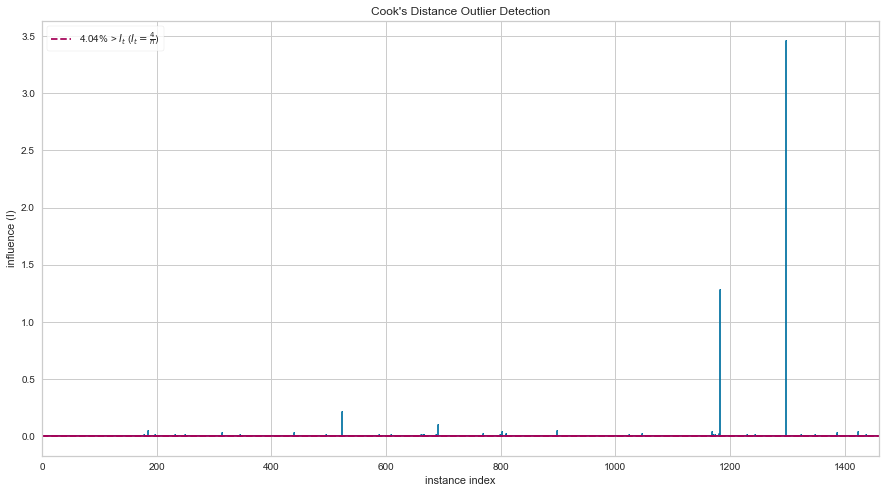

In [14]:
plt.figure(figsize=(15,8))
from yellowbrick.regressor import CooksDistance
visualizer = CooksDistance();
visualizer.fit(X_cook, y);
print("Ames Housing Data Outlier %ge: {:.2f}\n".format(visualizer.outlier_percentage_))
visualizer.show();

In [15]:
# Get indices of the 2 samples which fair exceed our outlier influence threshold
X_cook[visualizer.distance_ > visualizer.influence_threshold_ + 0.5] # 1182 & 1298

,MSSubClass,LotFrontage,LotArea,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold
1182,60,160.0,15623,4,10,5,1996,1996,0.0,5,...,78,0,0,0,555,5,3,0,7,2007
1298,60,313.0,63887,4,10,5,2008,2008,796.0,5,...,292,0,0,0,480,4,0,0,1,2008


In [16]:
# Drop them from our training dataset
X.drop(index=[1182, 1298], inplace=True)
y.drop(index=[1182, 1298], inplace=True)
X.reset_index().drop(columns=["index"])
y.reset_index().drop(columns=["index"])

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1453,175000
1454,210000
1455,266500
1456,142125


## 5. Feature Engineering

## Dealing with our remaining Categorical Features
- Are our features of the right type?
- Analysing Features which might be Imbalanced, Seasonal or Highly Correlated & Extracting them
- Label Encode the Remaining Ordinal Categorical Features
- One-Hot-Encoding of our Nominal Categorical Features

In [17]:
# Get remaining un-encoded features
remaining_features = X.columns[~X.columns.isin(missing_vals_df.index)]
remaining_features

Index(['MSSubClass', 'LotArea', 'Street', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond',
       'Foundation', 'Heating', 'HeatingQC', 'CentralAir', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'SaleCondition'],
      dtype='object')

### MSSubClass
Numerical Features, but each number is actually a nominal category which identifies the type of dwelling involved, thus we will convert it into a Category. (i.e. convert to String)

### YrSold & MoSold
Years with financial crises such as the 2008 Global Financial Crisis which was due to subprime mortgages might have a severe effect on SalePrice, thus we should account for such seasonality. Other monthly seasonal trends are also worth looking at.

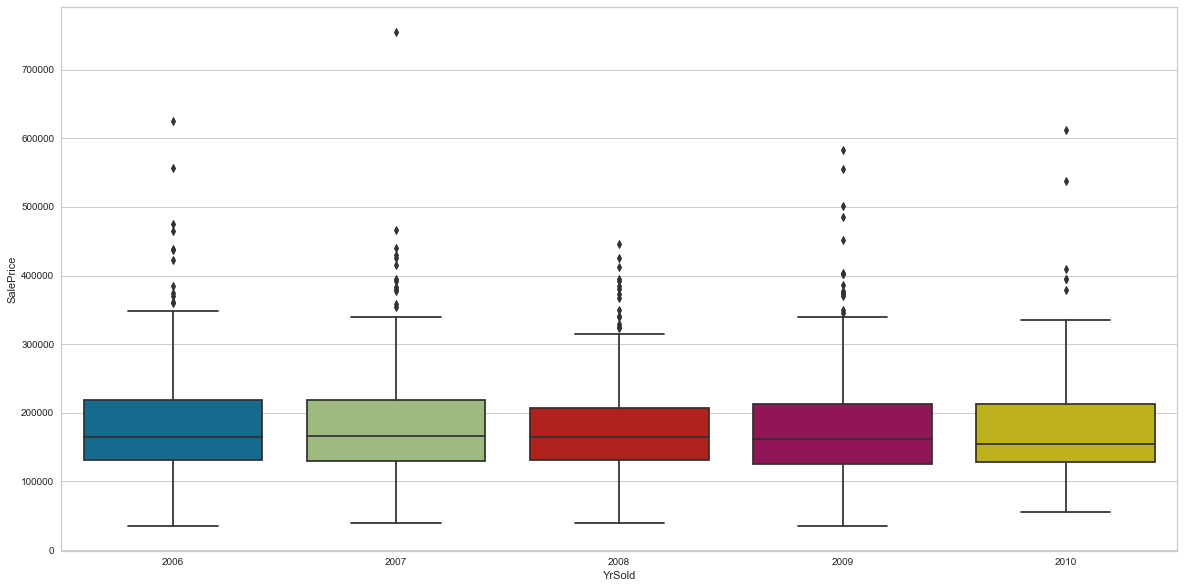

In [18]:
plt.figure(figsize=(20,10))
X_clean = handle_missing(X)
sns.boxplot(X_clean.YrSold, y);

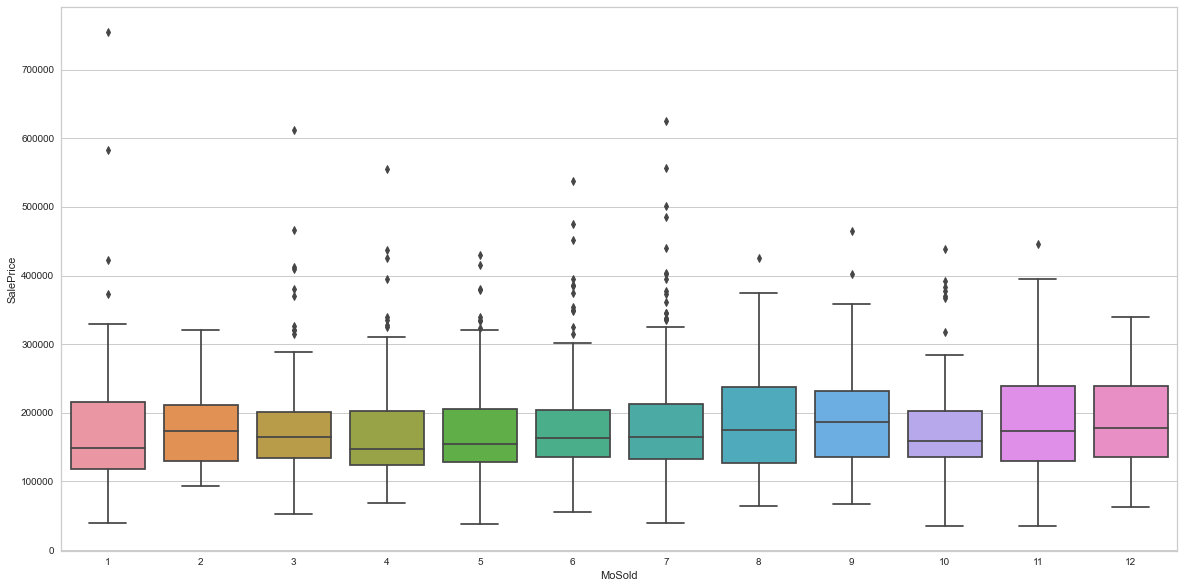

In [19]:
plt.figure(figsize=(20,10))
sns.boxplot(X_clean.MoSold, y);

SalePrices over the years seem to be fairly stable, with little seasonality, thus we will leave YrSold unmodified. On the other hand, against MoSold, SalePrices seem to rise towards the later months of the year, especially from September onwards up till December, however, the rise in SalePrice is not consistent and not very significant.

### YearBuilt
The age of a home may have an effect on its SalePrice, with newer homes possibly fetching higher prices. We observe especially high prices for the latest homes built in the 2010s. Thus we could include an Age feature to capture this, where <b>Age = 2010 - YearBuilt.</b>

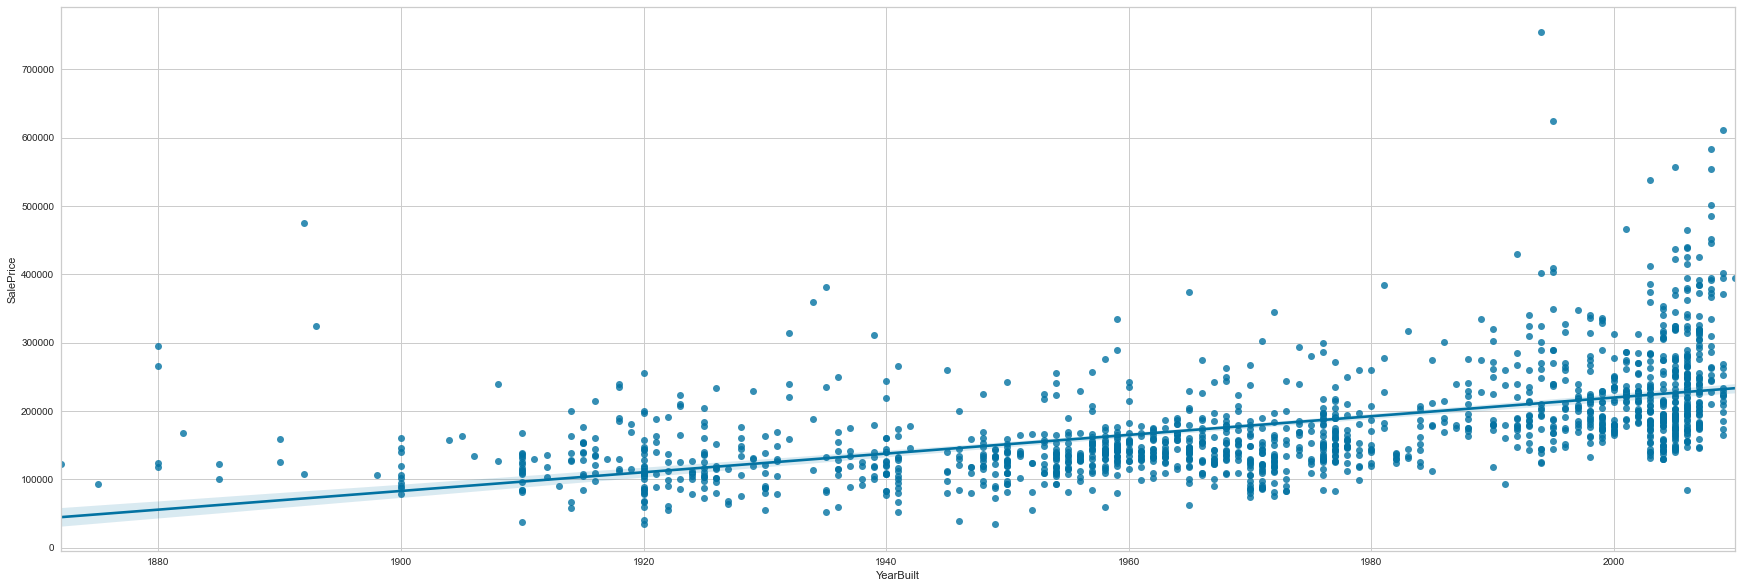

In [20]:
plt.figure(figsize=(30,10))
sns.regplot(X_clean.YearBuilt, y);

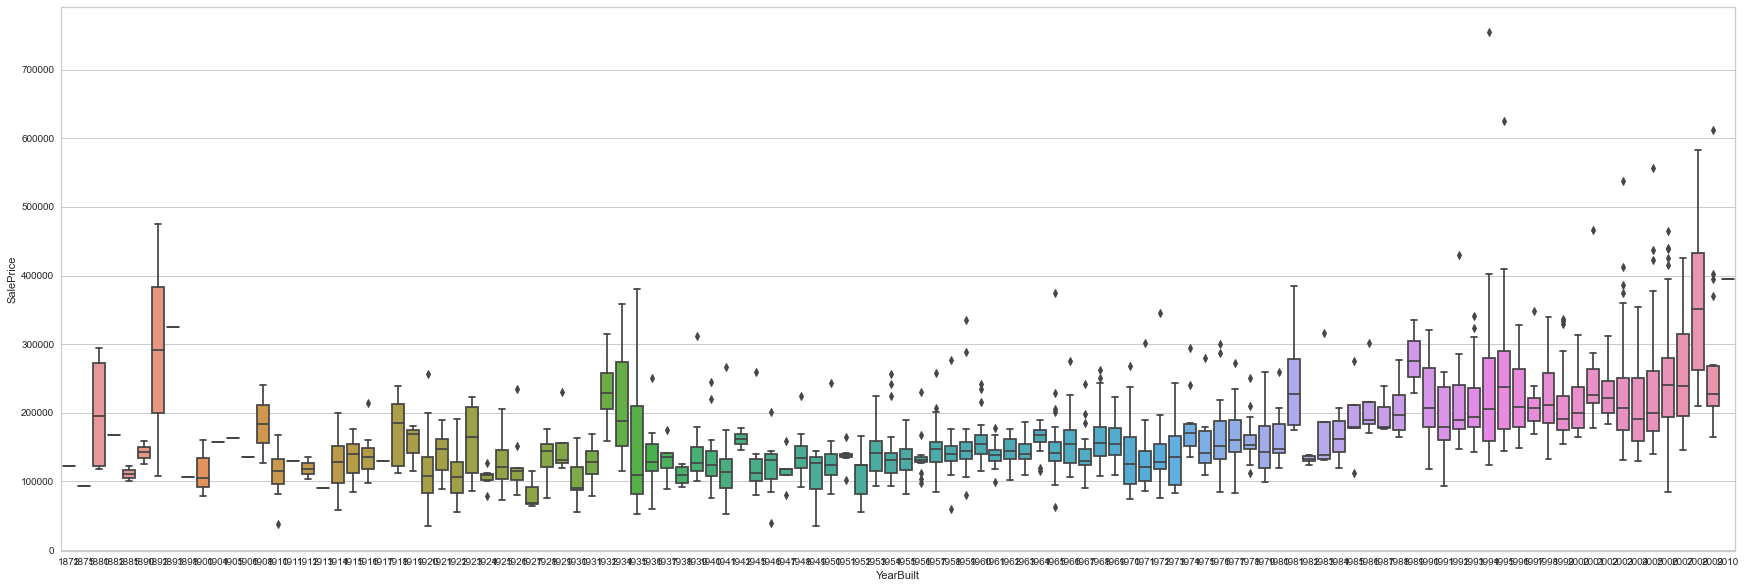

In [21]:
plt.figure(figsize=(30,10))
sns.boxplot(X_clean.YearBuilt, y);

### YrRemodAdd
Home that have been remodeled before might fetch higher prices than home that were sold as is. Further, if the home was remodelled in the year it was sold, it might have fetched an ever higher price.

In [22]:
X_remodelled = X_clean.copy()
X_remodelled["Remodelled"] = (X_clean.YearRemodAdd != X_clean.YearBuilt)
X_remodelled.Remodelled

0       False
1       False
2        True
3        True
4       False
        ...  
1455     True
1456     True
1457     True
1458     True
1459    False
Name: Remodelled, Length: 1458, dtype: bool

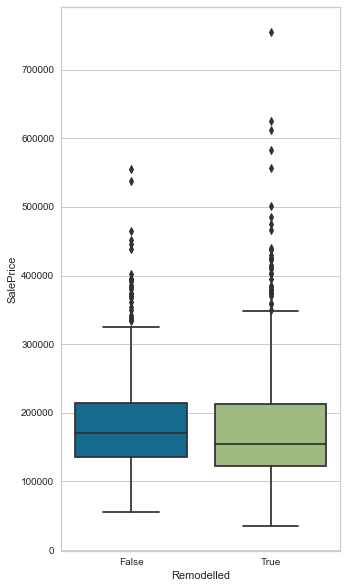

In [23]:
plt.figure(figsize=(5,10))
sns.boxplot(X_remodelled.Remodelled, y);

Remodelling seems to drive down the SalePrice slighlty, however, we see a large number of positive outliers for True. We can also consider a the number of years since remodelling, since newly remodelled homes might fetch higher SalePrices, i.e. <b>YearsSinceRemod</b>.

### Living Area Features
The area features might all be highly correlated with one another, thus we should plot a correlation matrix to investigate. Further, we could also create an overall size feature TotalSF to capture the overall size of the home.

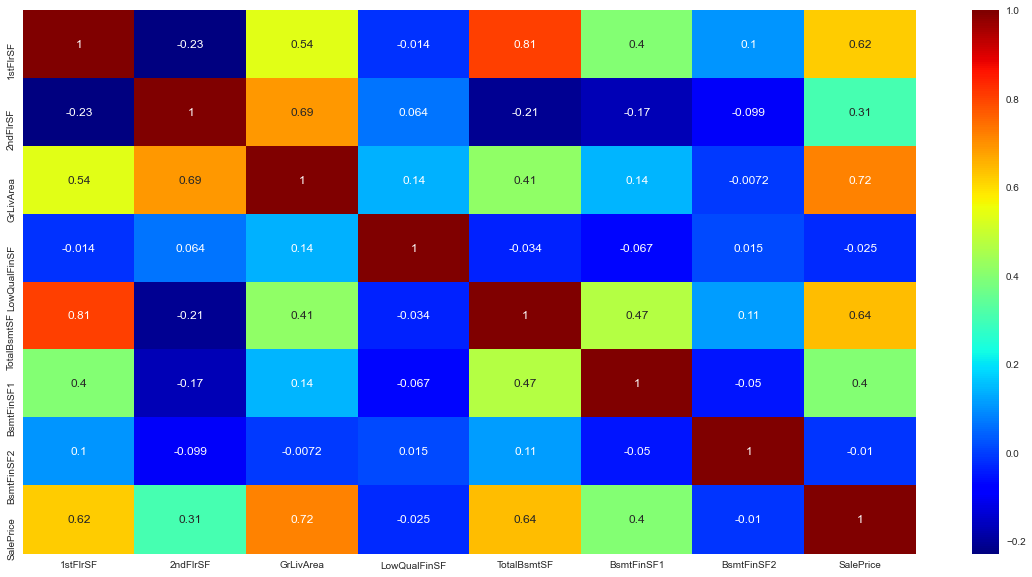

In [24]:
plt.figure(figsize=(20,10))
SF_features = pd.concat([X_clean[["1stFlrSF", "2ndFlrSF", "GrLivArea", "LowQualFinSF", "TotalBsmtSF", "BsmtFinSF1", "BsmtFinSF2"]], y], axis=1)
sns.heatmap(SF_features.corr(), annot=True, cmap='jet');

We observe high correlation between 1stFlrSF, GrLivArea & TotalBsmtSF and SalePrice. Further, there is high correlation between 1st & 2nd Flr SF and GrLivArea as well as TotalBsmtSF an 1stFlrSF. Thus, we can create TotalSF = GrLivArea + TotalBsmtSF.

### Porch Features
WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, SCreenPorch can be combined to create a single Total Porch Area feature, totPorchArea, which captures the size of the Porch and Deck area of the home. We can also consider adding this to a Total Home Living Area feature instead, like TotalSF above.

<ipython-input-25-23bbd0a18c77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_porch["TotPorchSF"] = np.sum(X_porch, axis=1)


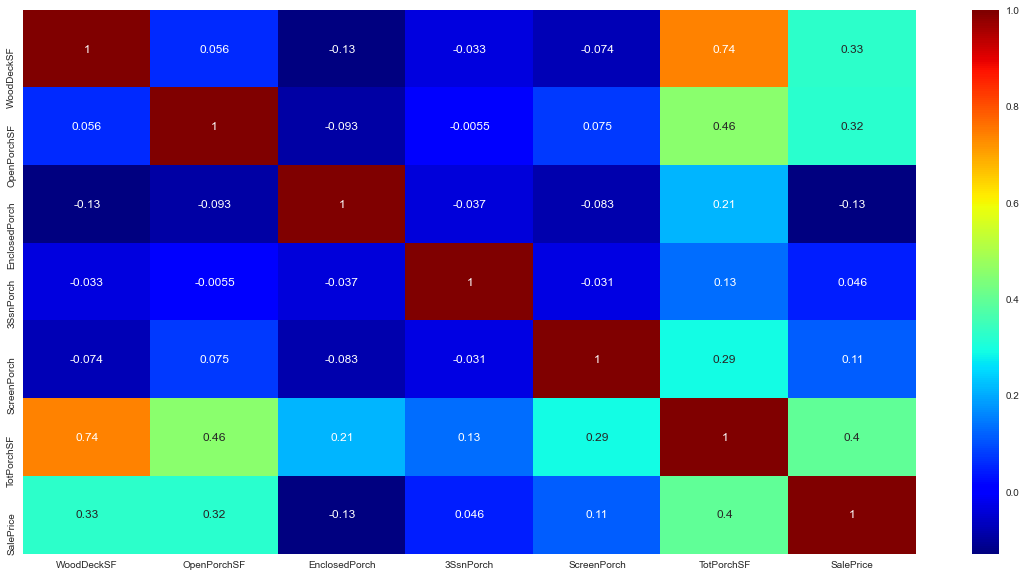

In [25]:
plt.figure(figsize=(20,10))
X_porch = X_clean[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]]
X_porch["TotPorchSF"] = np.sum(X_porch, axis=1)
sns.heatmap(pd.concat([X_porch, y], axis=1).corr(), annot=True, cmap='jet');

TotPorchSF yields us the highest pearson correlation coefficient amongst our Porch & Deck features.

### Bath Features
The no. of full and half bathrooms above ground and in the basement are aplit amongst 4 features. However, we can combine them to obtain the total number of bathrooms, which might be useful in explaining home Saleprices.

<ipython-input-26-3257b63ad2ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_baths["TotNumBaths"] = np.sum(X_baths, axis=1)


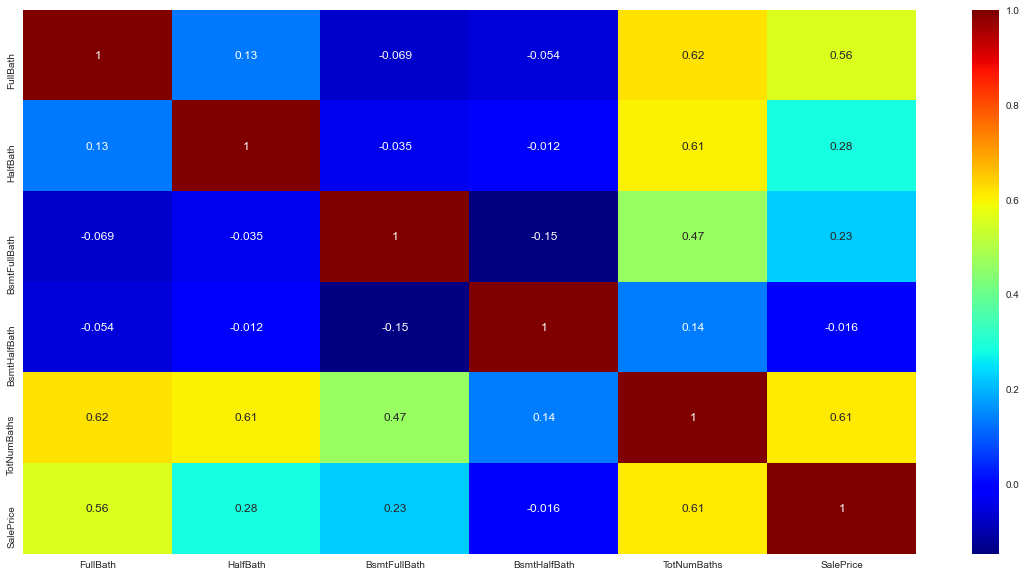

In [26]:
plt.figure(figsize=(20,10))
X_baths = X_clean[["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]]
X_baths["TotNumBaths"] = np.sum(X_baths, axis=1)
sns.heatmap(pd.concat([X_baths, y], axis=1).corr(), annot=True, cmap='jet');

SalePrice is most highly correlated with TotNumBaths at 0.61, thus we will incorporate this into our dataset.

### Pool Features
Pool Area can be incorporated into our TotalSF feature, to capture the total living/ recreational space of the home.

### Other Features within the Home (Rooms, Kitchens & Fireplaces)
BedroomAbvGrd, KitchenAbvGrd, TotRmsAbvGrd & Fireplace might not offer any additional insight from feature extraction or engineering. Thus, we will leave them unchanged for now.

### Rooms Features
BedroomAbvGrd, KitchenAbvGrd & TotRmsAbvGrd might not offer any additional insight from feature extraction. Thus, we will leave them unchanged for now.

### Misc. Features
MiscVal & MiscFeature, may add value to the home and thus its SalePrice. Thus, we should explore its implication with regard to SalePrice

In [27]:
X_misc = X_clean[["MiscFeature", "MiscVal"]]
# Distribution of MiscFeatures 
X_misc.MiscFeature.value_counts()

None    1404
Shed      49
Othr       2
Gar2       2
TenC       1
Name: MiscFeature, dtype: int64

In [28]:
# Median Value of these MiscFeatures
X_misc.groupby(by=["MiscFeature"]).median()

,MiscVal
MiscFeature,
Gar2,11900
None,0
Othr,1750
Shed,500
TenC,2000


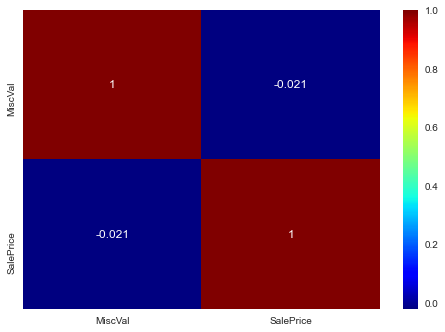

In [29]:
# How do they stack up against saleprice
sns.heatmap(pd.concat([X_misc, y], axis=1).corr(), annot=True, cmap='jet');

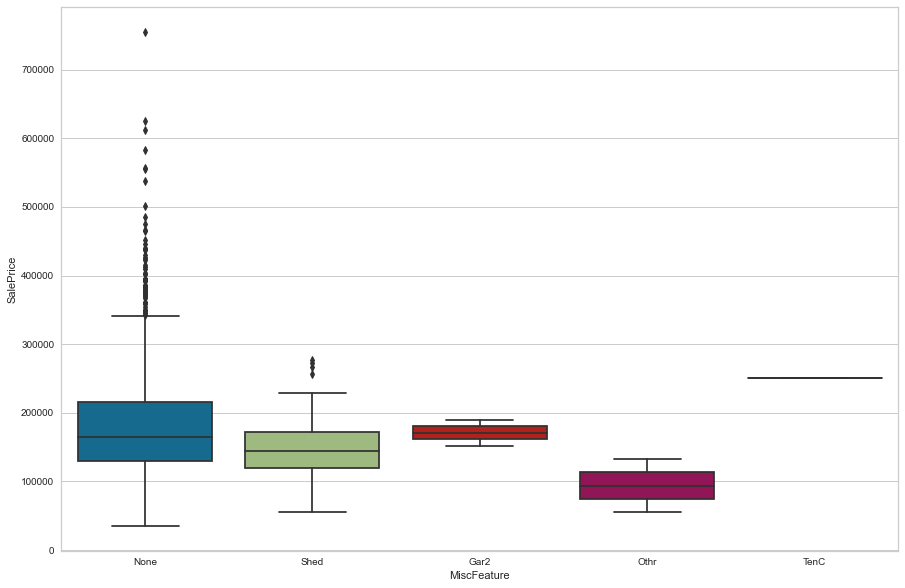

In [30]:
plt.figure(figsize=(15,10))
sns.boxplot(X_misc.MiscFeature, y);

Given that a large majority of homes do not have any MiscFeatures and since Misc. Features dont necessarily increase SalePrices, we will not engineer this feature. We can consider dropping <b>Elev</b> since no home has an elevator and adding a feature, <b>HasMisc</b>.

### Sale Condition
Abnormal sales due to foreclosures etc. might yield lower SalePrices.

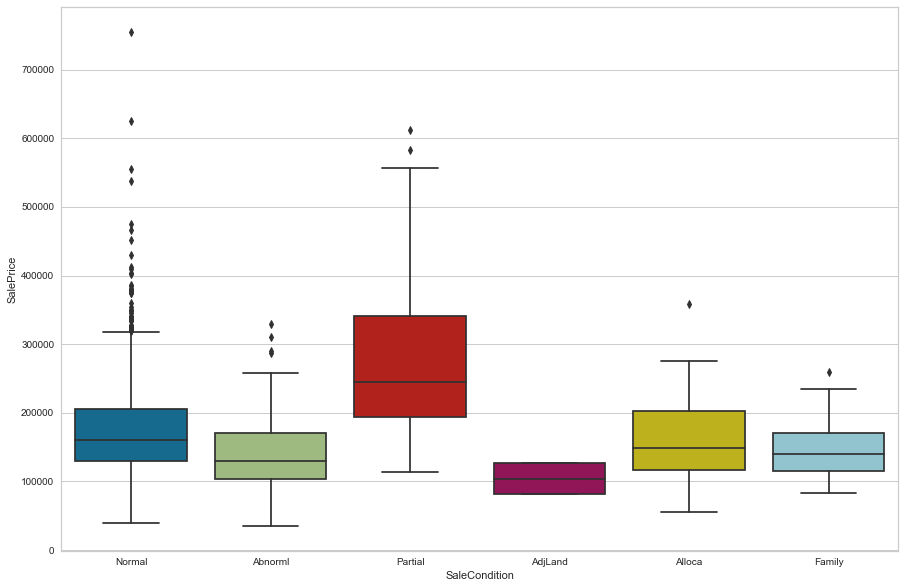

In [31]:
plt.figure(figsize=(15,10))
sns.boxplot(X_clean.SaleCondition, y);

In [32]:
X_clean.SaleCondition.value_counts()

Normal     1198
Partial     124
Abnorml     100
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In this scenario, most of our homes are Normal, Partial or Abnormal. However, since Normal & Partial SaleConditions refer to homes that were bought before being fully developed or resale, there were no extenuating circumstances surrounding the purchase. Further, Normal & Partial homes fetched higher prices, though marginally for Normal. Therefore, we can ordinally encode Normal/ Partial as 1 and the rest as 0.

### Street
Paved streets might add more valued to the SalePrice than Gravel streets.

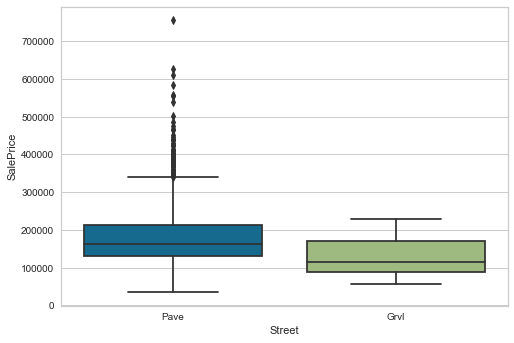

In [33]:
sns.boxplot(X_clean.Street,y);

In [34]:
X_clean.Street.value_counts()

Pave    1452
Grvl       6
Name: Street, dtype: int64

### PavedDrive
Paved Driveways in a home might fetch higher Saleprices.

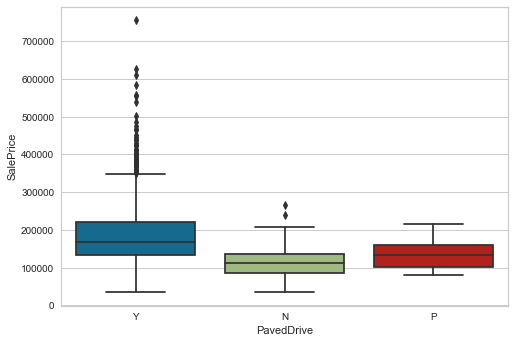

In [35]:
sns.boxplot(X_clean.PavedDrive,y);

In [36]:
X_clean.PavedDrive.value_counts()

Y    1338
N      90
P      30
Name: PavedDrive, dtype: int64

Ordinality observed.

### Lot & Land Features 
As we are unsure if the following Lot & Land features (i.e. LotShape, LandContour, LotConfig, LandSlope) do indeed have an association with SalePrice, we will explore them before deciding on whether to Label Encode or One Hot Encode these features.

In [37]:
X_lot_land = X_clean[["LotShape", "LandContour", "LotConfig", "LandSlope"]]

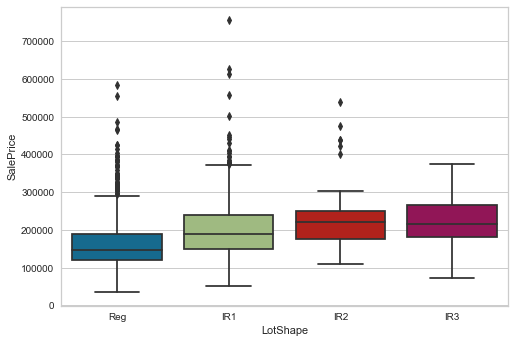

In [38]:
# LotShape
sns.boxplot(X_lot_land.LotShape, y);

In [39]:
X_lot_land.LotShape.value_counts() 

Reg    925
IR1    483
IR2     41
IR3      9
Name: LotShape, dtype: int64

We can consider adding an additional feature, <b>IsRegular<b>, since IR1,2,3 have similar SalePrices as compared to Reg, esp. IR2 & IR3.

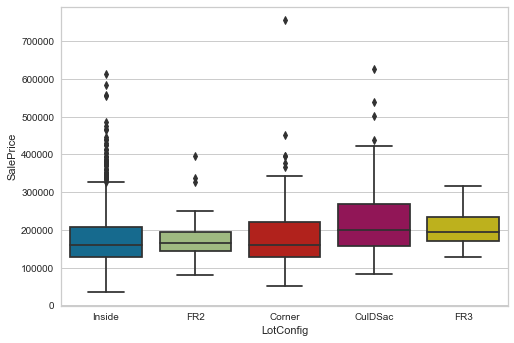

In [40]:
# LotConfig
sns.boxplot(X_lot_land.LotConfig, y);

In [41]:
X_lot_land.LotConfig.value_counts() 

Inside     1052
Corner      261
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Similar SalePrices across all types of configurations and given the nature of the categories, nominal, difficult to extract any binary or ternary features. Thus we will simply One Hot Encode.

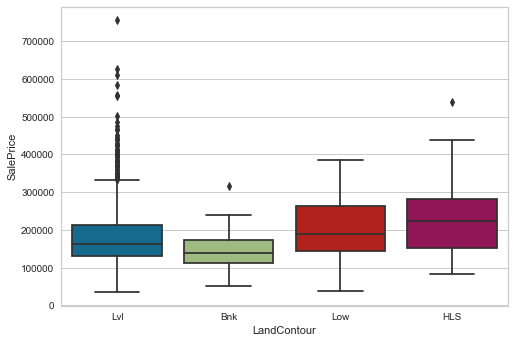

In [42]:
# LandContour
sns.boxplot(X_lot_land.LandContour, y);

In [43]:
X_lot_land.LandContour.value_counts() 

Lvl    1310
Bnk      62
HLS      50
Low      36
Name: LandContour, dtype: int64

Hillside homes have a much higher SalePrice vs. the other types of LandContours. However, it seems appropriate to add a <b>IsLevel</b> feature to help our model better distinguish between Levelled Land Contour types and the others, since it forms aa large majority of our homes in our dataset.

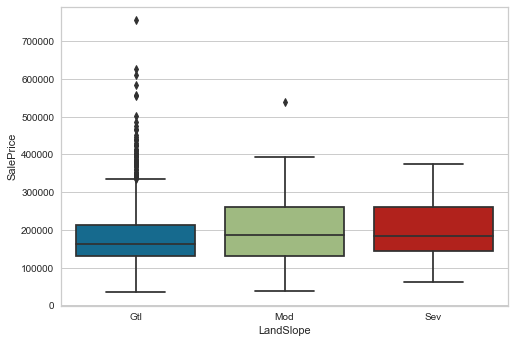

In [44]:
# LandSlope
sns.boxplot(X_lot_land.LandSlope, y);

In [45]:
X_lot_land.LandSlope.value_counts() 

Gtl    1380
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Similarly, homes with gentle slopes seem to sell for less, and form a large majority of our dataset. Hence we can also add a <b>IsGtl</b> feature to capture this distinction.

#### Condition1 & Condition2
Proximity to various conditions, might be useful, but given the numerous number of categorize, we might not be able to glean or extract any further useful information. Thus, we will simply One Hot Encode.

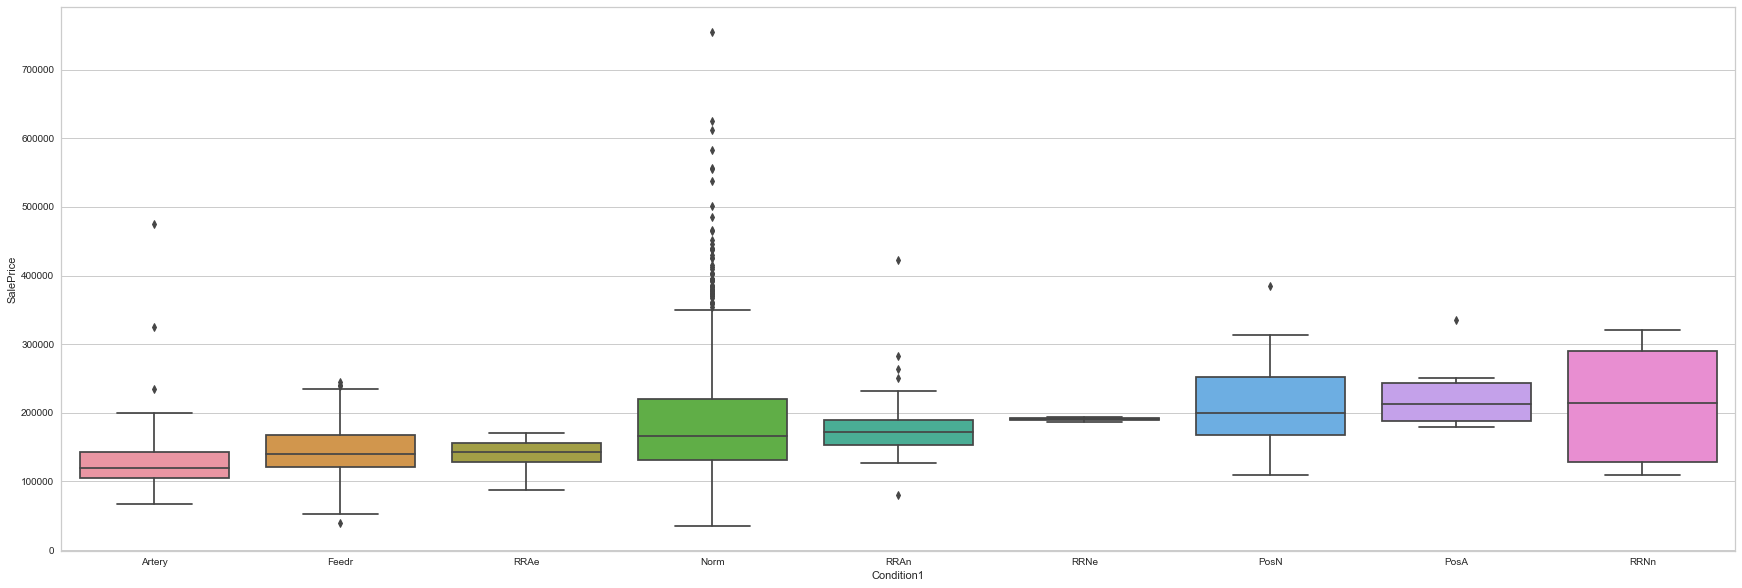

In [46]:
plt.figure(figsize=(30,10))
idx = pd.concat([X_clean[["Condition1"]], y], axis=1).groupby(by=["Condition1"]).median().sort_values(by="SalePrice").index
sns.boxplot(X_clean.Condition1, y, order=idx);

In [47]:
X_clean.Condition1.value_counts()

Norm      1259
Feedr       80
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [48]:
X_clean.Condition2.value_counts()

Norm      1443
Feedr        6
RRNn         2
PosN         2
Artery       2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

We could similarly consider adding a feature <b>IsNormCond1 & IsNormCond2</b> for both conditions given that a majority of homes are of the category Norm. However, it is difficult to bin or label encode these features given large number of outliers for Norm. Thus, it might not be useful to ordinally arrange them given the low support for labels with high ordinality.

### Style Features
No clear ordinality amongst Roof & House Style features, thus we will simply One Hot Encode.

### Infrastructural Features
No clear ordinality amongst RoofMatl, BldgType, Foundation, Heating features. Thus, we will One Hot Encode them.

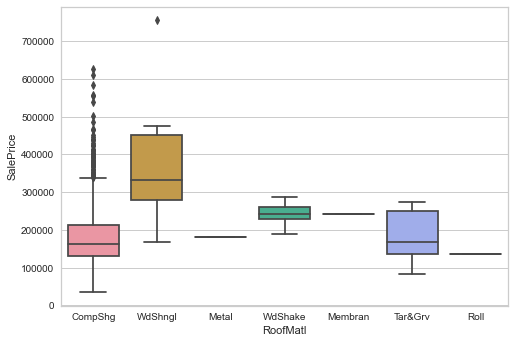

In [49]:
sns.boxplot(X_clean.RoofMatl, y);

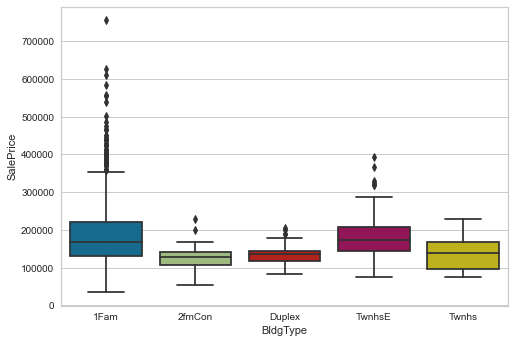

In [50]:
sns.boxplot(X_clean.BldgType, y);

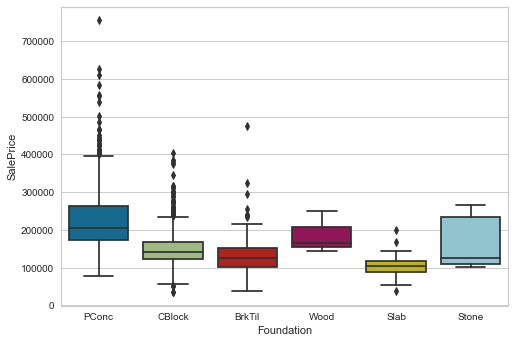

In [51]:
sns.boxplot(X_clean.Foundation, y);

In [52]:
X_clean.Foundation.value_counts() # No Majority

PConc     645
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

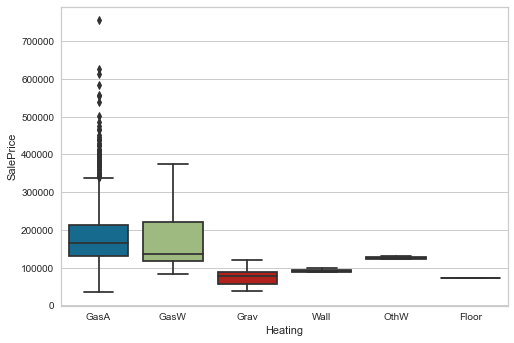

In [53]:
sns.boxplot(X_clean.Heating, y); # HeatingQC already covers ordinality

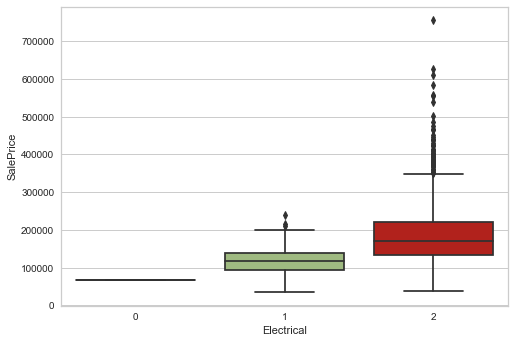

In [54]:
sns.boxplot(X_clean.Electrical, y); # HeatingQC already covers ordinality

#### Binning by Neighbourhood
Different Neighobourhoods might command different SalePrices due to convenience or other socio-economic factors, thus we should uncover any trends if they do exist and bin the neighbourhoods based on their distinct SalePrice ranges.

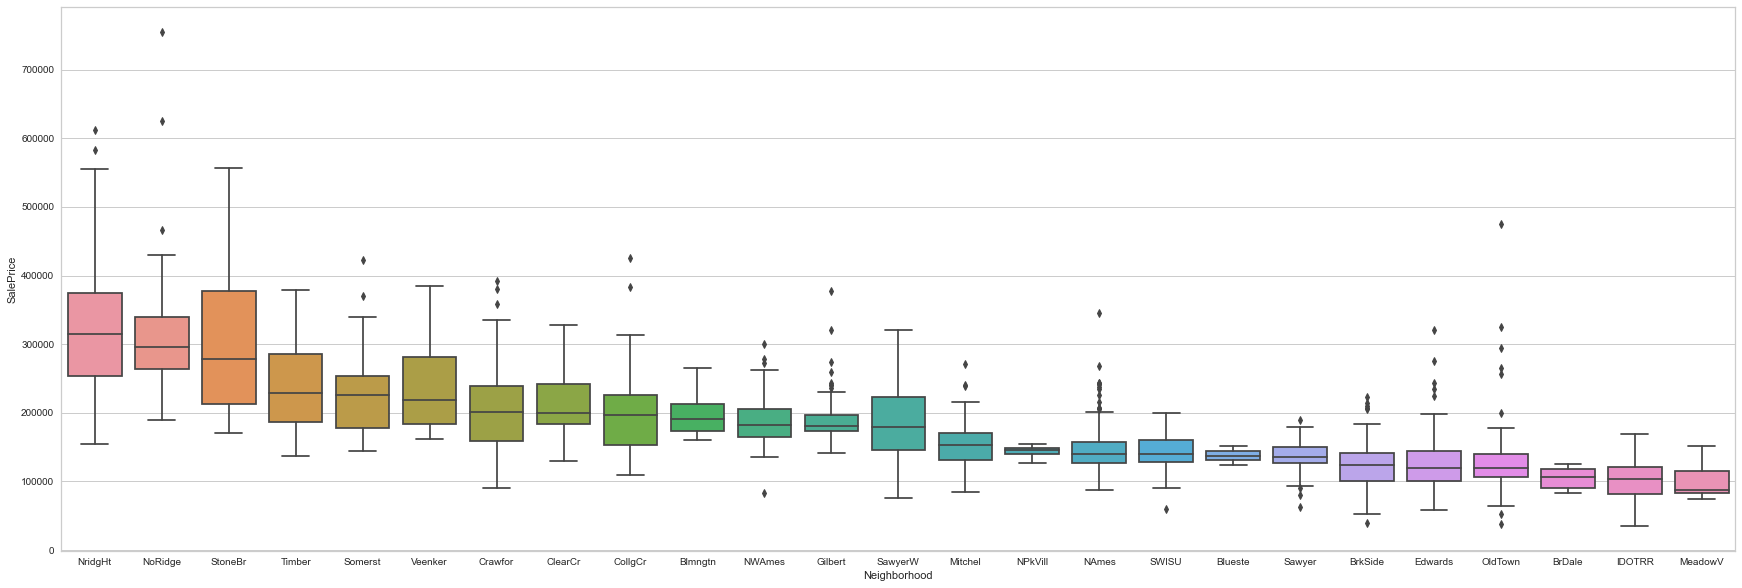

In [55]:
plt.figure(figsize=(30,10))
X_neighbourhood = pd.concat([X_clean.Neighborhood, y], axis=1)
order = X_neighbourhood.groupby("Neighborhood").median().sort_values(by = "SalePrice", ascending=False).index
sns.boxplot(X_clean.Neighborhood, y, order = order);

In [56]:
# We can separate them based on their Median SalePrices into 3 Classes of Neighbourhoods
# Neighborhood_Top = SalePrice >= 200000
# Neighborhood_Mid = SalePrice < 200000 & SalePrice >= 150000
# Neighborhood_Low = SalePrice < 150000
X_neighbourhood_median = X_neighbourhood.groupby("Neighborhood").median().sort_values(by = "SalePrice", ascending=False)

In [57]:
# Top
Neighborhood_Top = X_neighbourhood_median[X_neighbourhood_median >= 200000]
Top_Neighbourhoods = Neighborhood_Top[~np.isnan(Neighborhood_Top.SalePrice)].index.tolist()
Top_Neighbourhoods

['NridgHt',
 'NoRidge',
 'StoneBr',
 'Timber',
 'Somerst',
 'Veenker',
 'Crawfor',
 'ClearCr']

In [58]:
# Mid
Neighborhood_Mid = X_neighbourhood_median[(X_neighbourhood_median >= 150000) & (X_neighbourhood_median < 200000)]
Mid_Neighbourhoods = Neighborhood_Mid[~np.isnan(Neighborhood_Mid.SalePrice)].index.tolist()
Mid_Neighbourhoods

['CollgCr', 'Blmngtn', 'NWAmes', 'Gilbert', 'SawyerW', 'Mitchel']

In [59]:
# Low 
Neighborhood_Low = X_neighbourhood_median[X_neighbourhood_median < 150000]
Low_Neighbourhoods = Neighborhood_Low[~np.isnan(Neighborhood_Low.SalePrice)].index.tolist()
Low_Neighbourhoods

['NPkVill',
 'NAmes',
 'SWISU',
 'Blueste',
 'Sawyer',
 'BrkSide',
 'Edwards',
 'OldTown',
 'BrDale',
 'IDOTRR',
 'MeadowV']

In [60]:
def handle_cat_features(X):
    X_cleaned = X.copy()
    
    # MSSubClass
    X_cleaned["MSSubClass"]=X_cleaned["MSSubClass"].astype(str)
    
    # Age Feature
    X_cleaned["Age"] = 2010 - X_cleaned["YearBuilt"]
    
    # Remodelled Feature
    X_cleaned["Remodelled"] = (X_cleaned["YearRemodAdd"] != X_cleaned["YearBuilt"]).astype(int)
    
    # Years Since Remodelling
    X_cleaned["YrsSinceRemod"] = 2010 - X_cleaned["YearRemodAdd"]
    
    # TotalBldgSF Feature
    X_cleaned["TotalBldgSF"] = np.sum(X_cleaned[["GrLivArea", "TotalBsmtSF", "GarageArea", "PoolArea"]], axis=1)
    
    # TotalPorchSF Feature
    X_cleaned["TotalPorchSF"] = np.sum(X_cleaned[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]], axis=1)
        
    # NumBaths Feature
    X_cleaned["NumBaths"] = np.sum(X_cleaned[["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]], axis=1)
    
    # Exterior Qual & Cond
    quality_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, np.nan: 0}
    X_cleaned["ExterQual"].replace(quality_map, inplace=True)
    X_cleaned["ExterCond"].replace(quality_map, inplace=True)
    
    # HeatingQC
    X_cleaned["HeatingQC"].replace(quality_map, inplace=True)
    
    # CentralAir (1 or 0)
    binary_map = {"Y": 1, "N":0}
    X_cleaned["CentralAir"].replace(binary_map, inplace=True)
    
    # Paved Drive
    paved_map = {"Y": 2, "P": 1, "N":0}
    X_cleaned["PavedDrive"].replace(paved_map, inplace=True)
    
    # SaleCondition
    sale_cond_map = {"Normal": 1, "Partial": 1, "Abnorml": 0, "AdjLand": 0, "Alloca": 0, "Family": 0}
    X_cleaned["SaleCondition"].replace(sale_cond_map, inplace=True)
    
    # Street
    street_map = {"Grvl": 1, "Pave": 0}
    X_cleaned["Street"].replace(street_map, inplace=True)
    
    # LotShape (Distinguish between Regular & Irregular Lot Shapes)
    lot_shape_map = {"Reg": 1, "IR1": 0, "IR2": 0, "IR3": 0}
    X_cleaned["IsRegLot"] = X_cleaned["LotShape"].replace(lot_shape_map)
    
    # LandContour
    lnd_cntr_map = {"Lvl": 1, "Bnk": 0, "HLS": 0, "Low": 0}
    X_cleaned["IsLevel"] = X_cleaned["LandContour"].replace(lnd_cntr_map)
    
    # LandSlope
    lnd_slope_map = {"Gtl": 1, "Mod": 0, "Sev": 0}
    X_cleaned["IsGtl"] = X_cleaned["LandSlope"].replace(lnd_slope_map)
    
    # Neighborhood Class Feature (Bin by saleprices)
    neighborhood_map = {'NridgHt': 2,'NoRidge': 2,'StoneBr': 2,'Timber': 2,'Somerst': 2,'Veenker': 2,'Crawfor': 2,'ClearCr': 2,
                       'CollgCr': 1, 'Blmngtn': 1, 'NWAmes': 1, 'Gilbert': 1, 'SawyerW': 1, 'Mitchel': 1,
                       'NPkVill': 0,'NAmes': 0,'SWISU': 0,'Blueste': 0,'Sawyer': 0,'BrkSide': 0,'Edwards': 0,'OldTown': 0,'BrDale': 0,'IDOTRR': 0,'MeadowV': 0}
    
    X_cleaned["NeighborhoodClass"] = X_cleaned["Neighborhood"].copy()
    X_cleaned["NeighborhoodClass"].replace(neighborhood_map, inplace=True)
    
    # One Hot Encoding of Nominal Categorical Features
    X_cleaned = pd.get_dummies(X_cleaned, prefix="_", columns=["MSSubClass", "MSZoning", "Alley", "Street", "LotShape", "LandContour", "LotConfig", "LandSlope",
                                               "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl",
                                              "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "GarageType", "MiscFeature", "SaleType"])
    
    return X_cleaned

### Feature Transformation & Selection: Identifying Non-Gaussian & Unimportant Features in the Training Data
- Identify our non-gaussian numerical features
- Identify unimportant features (using permutation importance) and consider dropping them

In [61]:
from sklearn.preprocessing import power_transform

### Target Feature, SalePrice is non Gaussian

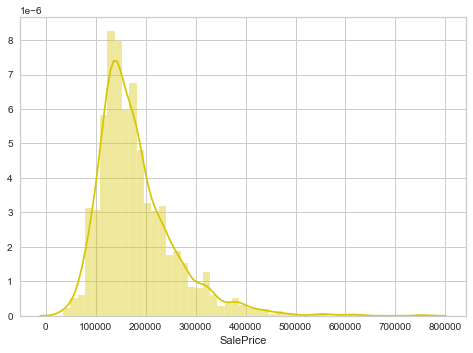

In [62]:
# Target Variable
sns.distplot(y, color='y');

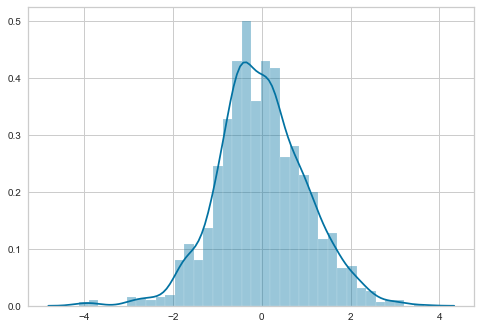

In [63]:
# Transform SalePrice via box-cox
y_np = y.to_numpy()
y_np = y_np.reshape((-1, 1))
y_transform = power_transform(y_np, method="box-cox")
sns.distplot(y_transform, color='b');

### Other Features of Natural Numerical Origin (i.e. Square Feet & Area Features)

In [64]:
# Identify Numerical Features of Natural Origin
X_handled = handle_cat_features(X_cleaned)
num_feat_df = X_handled[["TotalPorchSF", "TotalBldgSF", "LotArea", "LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
          "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch",
          "PoolArea"]].copy()

num_cols = num_feat_df.columns.values.tolist()
num_cols

['TotalPorchSF',
 'TotalBldgSF',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea']

In [65]:
# Identify features which are non-gaussian (i.e. Skew exceeds [-1, 1]; Kurtosis exceeds [-2, 2])
from scipy.stats import skew, kurtosis

def get_skew_kurt(df):
    distr_df = pd.DataFrame(columns=["Feature", "Skew", "Kurtosis"])
    for i in range(len(df.columns)):
        Skew = skew(df.iloc[:, i])
        Kurtosis = kurtosis(df.iloc[:, i])
        distr_df.loc[i] = [df.columns[i], Skew, Kurtosis]
    return distr_df

In [66]:
distr_df = get_skew_kurt(num_feat_df)
distr_df[(distr_df.Skew > 1) | (distr_df.Skew < -1) | (distr_df.Kurtosis > 2) | (distr_df.Kurtosis < -2)]

,Feature,Skew,Kurtosis
0,TotalPorchSF,1.376649,3.874853
1,TotalBldgSF,1.369462,8.154089
2,LotArea,12.822431,264.496632
3,LotFrontage,1.674852,14.170670
4,MasVnrArea,2.613592,9.318376
5,BsmtFinSF1,1.425230,6.890172
6,BsmtFinSF2,4.146143,18.810079
8,TotalBsmtSF,1.156894,9.105153
9,1stFlrSF,1.469604,6.942514
11,LowQualFinSF,12.088761,174.631256


In [67]:
def make_gaussian(X, cols):
    X_gaussian = X.copy()    
    for col in cols:
        feature_np = (X_gaussian[col].to_numpy()).reshape((-1,1))
        feature_transform = power_transform(feature_np) # Allow power transform to determine if Yeo-Johnson/ Box-Cox
        X_gaussian[col] = feature_transform
    return X_gaussian

In [68]:
# Apply Power Transform and obtain new Skew/ Kurtosis
gaussian_num_feat = make_gaussian(num_feat_df, num_cols)
gaussian_distr_df = get_skew_kurt(gaussian_num_feat)
gaussian_distr_df

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


,Feature,Skew,Kurtosis
0,TotalPorchSF,-0.353278,-0.544551
1,TotalBldgSF,0.034289,1.271492
2,LotArea,0.000000,-3.000000
3,LotFrontage,0.174681,4.117470
4,MasVnrArea,0.457330,-1.754787
5,BsmtFinSF1,-0.400682,-1.495537
6,BsmtFinSF2,2.355271,3.547420
7,BsmtUnfSF,-0.276617,-0.301972
8,TotalBsmtSF,0.113047,4.062660
9,1stFlrSF,0.000000,-3.000000


In [69]:
# Which features are still skewed? (KIV since it might affect model precision)
gaussian_distr_df[(gaussian_distr_df.Skew > 1) | (gaussian_distr_df.Skew < -1) | (gaussian_distr_df.Kurtosis > 2) | (gaussian_distr_df.Kurtosis < -2)]

,Feature,Skew,Kurtosis
2,LotArea,0.000000,-3.000000
3,LotFrontage,0.174681,4.117470
6,BsmtFinSF2,2.355271,3.547420
8,TotalBsmtSF,0.113047,4.062660
9,1stFlrSF,0.000000,-3.000000
11,LowQualFinSF,8.365937,67.988894
12,GrLivArea,0.000000,-3.000000
16,EnclosedPorch,1.883152,1.546358
17,3SsnPorch,8.712332,73.904730
18,ScreenPorch,2.915215,6.498476


## 6. Data Preprocessing
- Split Data into Train, Validation & Test
- Impute Missing Data
- Handle Categorical Features
- Make Gaussian

In [70]:
# Process our train data
X_2 = make_gaussian(handle_cat_features(handle_missing(X)), num_cols)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [71]:
# Split into Training & Testing Sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_2, y, test_size=0.2, random_state=42)

# Apply transformations to our y features - training & validation sets
y_train = power_transform(y_train.to_numpy().reshape((-1,1)), method="box-cox")
y_val = power_transform(y_val.to_numpy().reshape((-1,1)), method="box-cox")

# Standardise our data independently to prevent Data Leakage
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_2 = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_2 = pd.DataFrame(scaler.fit_transform(X_val), columns=X_val.columns)

## 7. Baseline LASSO Model & Error Analysis
- Test a LASSO
- Evaluate Results
- Check for Permutation Importance of Features + Further Feature Selection (May be unnecessry since LASSO)
- Plot Learning & Validation Curves
- Hyperparameter Optimisation + Iterate

### LASSO Regression

In [72]:
from sklearn.linear_model import LassoCV
lasso_reg = LassoCV(cv=5, random_state=42, normalize=False)
lasso_reg.fit(X_train_2, np.ravel(y_train))
lasso_reg.get_params()

{'alphas': None,
 'copy_X': True,
 'cv': 5,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

### Evaluation & Error Analysis

#### R^2, MSE & RMSE

In [73]:
from sklearn.metrics import mean_squared_error
y_pred = lasso_reg.predict(X_val_2)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("LassoCV MSE on Training Subset: {:,.3f}".format(mse))
print("LassoCV RMSE on Training Subset: {:,.3f}".format(rmse))
print("LassoCV R-Squared on Training Subset {:,.3f}".format(lasso_reg.score(X_train_2, y_train)))

LassoCV MSE on Training Subset: 0.077
LassoCV RMSE on Training Subset: 0.278
LassoCV R-Squared on Training Subset 0.927


#### Cross Val Score

In [74]:
from sklearn.model_selection import cross_val_score
def cross_val_rmse(estimator, X, y, cv=5):
    rmse=np.mean(np.sqrt(-cross_val_score(estimator, X, y, cv=5, scoring="neg_mean_squared_error")))
    return rmse

In [75]:
print("LassoCV on Training Subset: {:,.3f}".format(cross_val_rmse(lasso_reg, X_train_2, np.ravel(y_train))))

LassoCV on Training Subset: 0.318


##### Hyperparameter Tuning: Alpha Selection

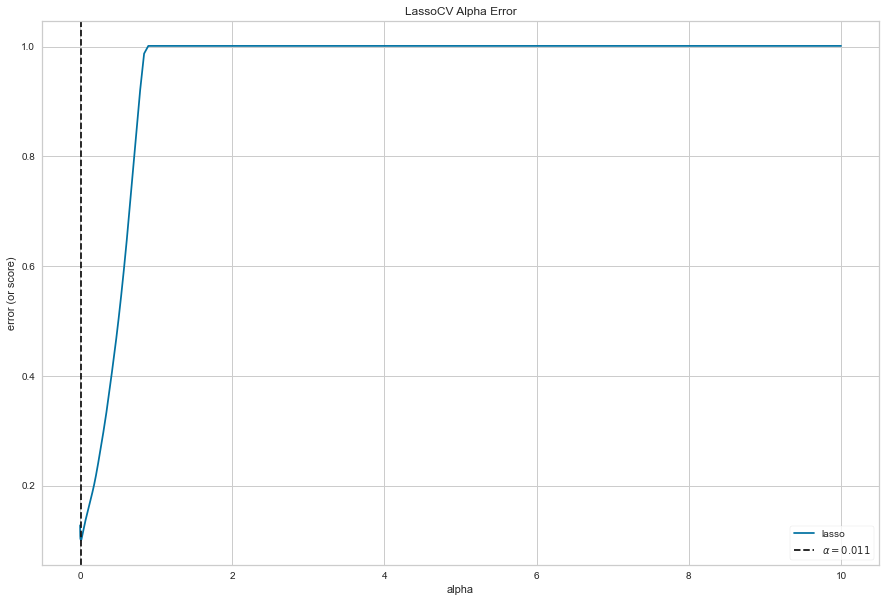

In [76]:
from yellowbrick.regressor import AlphaSelection
# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 400)
# Instantiate the linear model and visualizer
plt.figure(figsize=(15,10))
visualizer = AlphaSelection(LassoCV(cv=5, alphas=alphas, normalize=False, max_iter=10000, n_jobs=-1))
visualizer.fit(X_train_2, np.ravel(y_train))
visualizer.show();

Optimal Alpha = 0.011

#### Permutation Importance

In [77]:
from eli5.sklearn.permutation_importance import PermutationImportance
# Calculate Permutation Importance
lasso_reg_tuned = LassoCV(cv=5, random_state=42, normalize=False, alphas=[0.011])
lasso_reg_tuned.fit(X_train_2, np.ravel(y_train))
perm_results = PermutationImportance(lasso_reg_tuned).fit(X_val_2, y_val)

In [78]:
eli5.show_weights(perm_results, top=None ,feature_names = X_val_2.columns.values.tolist())

Weight,Feature
0.1712 ± 0.0161,TotalBldgSF
0.0474 ± 0.0123,OverallQual
0.0290 ± 0.0053,GrLivArea
0.0188 ± 0.0038,OverallCond
0.0146 ± 0.0071,NeighborhoodClass
0.0096 ± 0.0022,__C (all)
0.0089 ± 0.0049,Age
0.0051 ± 0.0011,BsmtUnfSF
0.0044 ± 0.0007,SaleCondition
0.0034 ± 0.0053,NumBaths


Negative Permutation Importances indicate, that these features are harming the predictive power of our LASSO model, thus we will drop these features from our dataset and retrain our LassoCV model. We will only <b>drop features with mean < 0.</b> 
    
However this might lead to poor variance and bias in our model, since we are feature selecting based solely on Lasso's predictive performance on the validation set, thus we must consider this as a plausible source of error. Therefore, we must further test this against our test set.

#### LASSO Coefficients
Identify and explore coefficients which have been shrunk down to 0.

In [79]:
lasso_coefs = lasso_reg_tuned.coef_
lasso_coefs_df = pd.DataFrame(np.c_[X_2.columns.values, lasso_coefs], columns=["Feature", "Coefficient"])
lasso_coefs_df[lasso_coefs_df.Coefficient == 0].Feature.tolist()

['LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'TotalBsmtSF',
 'Electrical',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'GarageYrBlt',
 'GarageArea',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'EnclosedPorch',
 '3SsnPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal',
 'MoSold',
 'Remodelled',
 'IsRegLot',
 'IsLevel',
 'IsGtl',
 '__120',
 '__180',
 '__190',
 '__40',
 '__45',
 '__50',
 '__60',
 '__70',
 '__75',
 '__80',
 '__85',
 '__90',
 '__FV',
 '__RH',
 '__Grvl',
 '__None',
 '__0',
 '__1',
 '__IR1',
 '__IR3',
 '__Reg',
 '__Bnk',
 '__Low',
 '__Lvl',
 '__Corner',
 '__FR2',
 '__FR3',
 '__Inside',
 '__Gtl',
 '__Mod',
 '__Sev',
 '__Blmngtn',
 '__Blueste',
 '__BrDale',
 '__ClearCr',
 '__CollgCr',
 '__Edwards',
 '__Gilbert',
 '__IDOTRR',
 '__NAmes',
 '__NPkVill',
 '__NoRidge',
 '__OldTown',
 '__SWISU',
 '__Sawyer',
 '__SawyerW',
 '__Somerst',
 '__Timber',
 '__Veenker',
 '__Feedr',
 '_

#### Retraining Model with Updated Dataset

In [80]:
# Process Data with Cols dropped
X_3 = X_2.drop(columns=["__Plywood", "FireplaceQu", "__Stucco", "BsmtQual", "1stFlrSF", "__HdBoard", "YrsSinceRemod", "ExterQual", "GarageQual",
                       "__30", "GarageFinish", "__Gable", "TotRmsAbvGrd", "__PConc", "KitchenQual", "__BrkComm", "__Grav"])

X_train, X_val, y_train, y_val = train_test_split(X_3, y, test_size=0.2, random_state=42)

# Apply transformations to our y features - training & validation sets
y_train = power_transform(y_train.to_numpy().reshape((-1,1)), method="box-cox")
y_val = power_transform(y_val.to_numpy().reshape((-1,1)), method="box-cox")

# Standardise our data independently to prevent Data Leakage
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_2 = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_2 = pd.DataFrame(scaler.fit_transform(X_val), columns=X_val.columns)

In [81]:
# Train Model
lasso_reg = LassoCV(cv=5, alphas=[0.011])
lasso_reg.fit(X_train_2, np.ravel(y_train))

LassoCV(alphas=[0.011], cv=5)

In [82]:
y_pred = lasso_reg.predict(X_val_2)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("LassoCV MSE on Validation Set: {:,.3f}".format(mse))
print("LassoCV RMSE on Validation Set: {:,.3f}".format(rmse))
print("LassoCV R-Squared on Validation Set: {:,.3f}".format(lasso_reg.score(X_train_2, y_train)))
print("LassoCV Cross Val RMSE on Validation Set: {:,.3f}".format(cross_val_rmse(lasso_reg, X_train_2, np.ravel(y_train))))

LassoCV MSE on Validation Set: 0.072
LassoCV RMSE on Validation Set: 0.268
LassoCV R-Squared on Validation Set: 0.924
LassoCV Cross Val RMSE on Validation Set: 0.316


There is no improvement (up to 3 d.p.) observed in any of our MSE, RMSE & R-Squared, however, there is a slight imporvedment of approximately 0.001 in our Cross Val RMSE. Thus, there was no significant impact from dropping our unimportant features. This is likely the case given that their negative permutation importance values are very small. Hence, we should plot our learning curves to further investigate the LASSO model and its performance.

Given that our optimiser is bouncing around the neighbourhood of our global minimum, this might be an indication of our LASSO model overfitting, we should plot learning curves for both the training & validation sets to investigate this. Also, given this issue we should consider other models such as <b>Elastic Net</b>.

## 8. Train LASSO on our entire Training Set

### Process & Fit our entire Train & Test Data

In [86]:
# Process and Split into our actual Train & Test Data
X_all = make_gaussian(handle_cat_features(handle_missing(combined_X)), num_cols)
X_train_all = X_all[: n_train]
X_train_all.drop(index=[1182, 1298], inplace=True)
y_train_all = y_transform

X_test_all = X_all[n_test: ]

# Standardise our Data
X_train_all_std = pd.DataFrame(scaler.fit_transform(X_train_all), columns=X_train_all.columns)
X_test_all_std = pd.DataFrame(scaler.fit_transform(X_test_all), columns=X_test_all.columns)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super()

In [87]:
lasso_reg = LassoCV(cv=5, alphas=[0.011], max_iter=15000) # Does not Converge, bouncing around, might be overfitting
lasso_reg.fit(X_train_all_std, np.ravel(y_train_all))

LassoCV(alphas=[0.011], cv=5, max_iter=15000)

### Evaluation & Error Analysis of our Lasso Model
#### RMSE

In [90]:
print("LassoCV Cross Val RMSE Full Training Set: {:,.3f}".format(cross_val_rmse(lasso_reg, X_train_all_std, np.ravel(y_transform))))

LassoCV Cross Val RMSE Full Training Set: 0.299


## 9. Write Wrangled Training to File to further Model Development

In [ ]:
# reset X_train_all index
# X_final = X_train_all.reset_index().drop(columns=["index"])
# X_final

In [ ]:
# y_transform = pd.DataFrame(y_transform, columns=["Saleprice"])
# y_final = y_transform.reset_index().drop(columns=["index"])
# y_final

In [ ]:
# Ouput processed Training Set
# train_clean = pd.concat([X_final, y_final], axis=1)

In [ ]:
# Write Processed Training Set to Dir.
# train_clean.to_csv("train_clean.csv", index=False)

In [ ]:
# Ouput processed Training Set
# train_clean = pd.concat([X_final, y_final], axis=1)

In [ ]:
# Write Processed Training Set to Dir.
# train_clean.to_csv("train_clean.csv", index=False)

In [ ]:
# Write Processed Test Set to Dir.
# X_test_all.to_csv("test_clean.csv", index=False)